In [3]:
from casadi import *

In [4]:
T = 10. # Time horizon
N = 20 # number of control intervals

# Declare model variables
x1 = MX.sym('x1')
x2 = MX.sym('x2')
x = vertcat(x1, x2)
u = MX.sym('u')

In [5]:
# Model equations
xdot = vertcat((1-x2**2)*x1 - x2 + u, x1)

# Objective term
L = x1**2 + x2**2 + u**2

In [6]:
# Formulate discrete time dynamics
if False:
    # CVODES from the SUNDIALS suite
    dae = {'x':x, 'p':u, 'ode':xdot, 'quad':L}
    opts = {'tf':T/N}
    F = integrator('F', 'cvodes', dae, opts)
else:
    # Fixed step Runge-Kutta 4 integrator
    M = 4 # RK4 steps per interval
    DT = T/N/M
    f = Function('f', [x, u], [xdot, L])
    X0 = MX.sym('X0', 2)
    U = MX.sym('U')
    X = X0
    Q = 0
    for j in range(M):
        k1, k1_q = f(X, U)
        k2, k2_q = f(X + DT/2 * k1, U)
        k3, k3_q = f(X + DT/2 * k2, U)
        k4, k4_q = f(X + DT * k3, U)
        X=X+DT/6*(k1 +2*k2 +2*k3 +k4)
        Q = Q + DT/6*(k1_q + 2*k2_q + 2*k3_q + k4_q)
    F = Function('F', [X0, U], [X, Q],['x0','p'],['xf','qf'])

In [7]:
# Evaluate at a test point
Fk = F(x0=[0.2,0.3],p=0.4)
print(Fk['xf'])
print(Fk['qf'])

[0.335539, 0.434784]
0.183287


In [8]:
# Start with an empty NLP
w=[]
w0 = []
lbw = []
ubw = []
J = 0
g=[]
lbg = []
ubg = []

In [9]:
# Formulate the NLP
Xk = MX([0, 1])
for k in range(N):
    # New NLP variable for the control
    Uk = MX.sym('U_' + str(k))
    w += [Uk]
    lbw += [-1]
    ubw += [1]
    w0 += [0]

    # Integrate till the end of the interval
    Fk = F(x0=Xk, p=Uk)
    Xk = Fk['xf']
    J=J+Fk['qf']

    # Add inequality constraint
    g += [Xk[0]]
    lbg += [-.25]
    ubg += [inf]

In [16]:
# Create an NLP solver
prob = {'f': J, 'x': vertcat(*w), 'g': vertcat(*g)}
solver = nlpsol('solver', 'ipopt', prob)

# Solve the NLP
sol = solver(x0=w0, lbx=lbw, ubx=ubw, lbg=lbg, ubg=ubg)
w_opt = sol['x']

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      210
Number of nonzeros in Lagrangian Hessian.............:      210

Total number of variables............................:       20
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       20
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       20
        inequality constraints with only lower bounds:       20
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

In [14]:
sol

{'f': DM(3.73297),
 'g': DM([-0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.213692, -0.148928, -0.0865315, -0.0394501, -0.00992498, 0.00513212, 0.0104556, 0.0103897, 0.00808826, 0.00543888, 0.00330615, 0.00184693, 0.000778207, -0.000429105]),
 'lam_g': DM([-2.5311, -2.63512, -1.86981, -1.23141, -0.723886, -0.203928, -6.90177e-08, -2.47931e-08, -1.53296e-08, -1.19017e-08, -1.0438e-08, -9.82196e-09, -9.62121e-09, -9.62364e-09, -9.70946e-09, -9.81016e-09, -9.89276e-09, -9.95008e-09, -9.99248e-09, -1.00408e-08]),
 'lam_p': DM([]),
 'lam_x': DM([3.19574e-09, 3.61786e-08, 1.63737e-08, 9.77429e-09, 6.47234e-09, 4.47492e-09, 3.79081e-09, 2.80715e-09, 1.67793e-09, 8.80245e-10, 3.68256e-10, 7.00658e-11, -7.39107e-11, -1.18441e-10, -1.09508e-10, -7.9555e-11, -4.7613e-11, -2.25769e-11, -7.07805e-12, -6.17874e-13]),
 'x': DM([0.486638, 0.933131, 0.858599, 0.775965, 0.685163, 0.58613, 0.537695, 0.447794, 0.30388, 0.170527, 0.0730852, 0.0139774, -0.0147441, -0.0236193, -0.0218395, -0.0158695, -0.009499

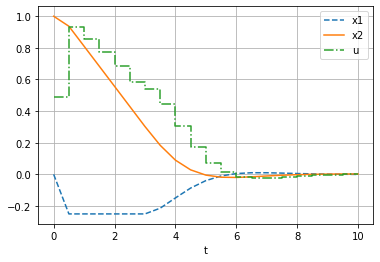

In [37]:
# Plot the solution
u_opt = w_opt
x_opt = [[0, 1]]
for k in range(N):
    Fk = F(x0=x_opt[-1], p=u_opt[k])
    x_opt += [Fk['xf'].full()]
x1_opt = [r[0] for r in x_opt]
x2_opt = [r[1] for r in x_opt]

tgrid = [T/N*k for k in range(N+1)]
import matplotlib.pyplot as plt
plt.figure(1)
plt.clf()
plt.plot(tgrid, x1_opt, '--')
plt.plot(tgrid, x2_opt, '-')
plt.step(tgrid, vertcat(DM.nan(1), u_opt), '-.')
plt.xlabel('t')
plt.legend(['x1','x2','u'])
plt.grid()
plt.show()